In [22]:
import os

import cv2
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

import scipy.ndimage

In [23]:
def create_mask_rgb(image):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image, Image.Image):
        image = np.array(image.convert("RGB"))

    # Separar los canales
    red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    # Aplicar las condiciones
    condition1 = (blue == 255) & (red == 0) & (green < 200)
    condition2 = (red == 0) & (green < 100)
    condition3 = (green == 255) & (blue > np.mean(blue))

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask = ((condition1 | condition2 | condition3) & (red <= np.mean(red)-np.std(red)*0.70))

    return mask.astype(np.uint8)  # Convertir a 0 y 1


def create_mask_hsv(image_hsv):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image_hsv, Image.Image):
        image_hsv = np.array(image_hsv.convert("RGB"))
        image_hsv = cv2.cvtColor(image_hsv, cv2.COLOR_RGB2HSV)

    # Separar los canales
    h, s, v = image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]

    # Aplicar las condiciones
    condition3 = (h > 50) & (s < 0.8*255) & (s > 0.5*255)
    condition4 = (h > 100) & (s > 0.7*255) 
    

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask = condition3 | condition4

    return mask.astype(np.uint8)  # Convertir a 0 y 1

In [24]:
def create_mask_rgb(image):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image, Image.Image):
        image = np.array(image.convert("RGB"))

    # Separar los canales
    red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    # Aplicar las condiciones
    condition1 = (blue == 255) & (red == 0) & (green < 200)
    condition2 = (red == 0) & (green < 150)
    condition3 = (green == 255) & (blue > np.mean(blue))

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask = ((condition1 | condition2 | condition3) & (red <= np.mean(red)-np.std(red)*0.30))

    return mask.astype(np.uint8)  # Convertir a 0 y 1


def create_mask_hsv(image_hsv):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image_hsv, Image.Image):
        image_hsv = np.array(image_hsv.convert("RGB"))
        image_hsv = cv2.cvtColor(image_hsv, cv2.COLOR_RGB2HSV)

    # Separar los canales
    h, s, v = image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]

    # Aplicar las condiciones
    condition3 = (h > 35) & (s > 0.5*255)
    condition4 = (h > 100) & (s > 0.7*255) 
    

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask = condition3 | condition4

    return mask.astype(np.uint8)  # Convertir a 0 y 1

In [25]:
def mean_intensity_per_component(img1, img2, mask):
    # Etiquetar los componentes conexos en la máscara
    labeled_mask, num_components = scipy.ndimage.label(mask)
    # plt.imshow(labeled_mask, cmap='nipy_spectral')
    # plt.colorbar()
    # plt.show()

    new_mask = np.zeros_like(labeled_mask)
    th = (np.mean(img1) + np.mean(img2))/2

    # Iterar sobre cada componente identificado
    for label in range(1, num_components + 1):
        component_mask = (labeled_mask == label)

        # Calcular la media en cada canal
        mean_1 = np.mean(img1[component_mask])
        mean_2 = np.mean(img2[component_mask])

        if np.abs(mean_1-mean_2) > th*(1-(np.std(img1) + np.std(img2))/2*0.01):
            new_mask[component_mask] = 1

    return new_mask

In [41]:
# 0: no está
# 1: movido
# 2: tapado

def threshold(heatmap1, heatmap2):

    mask_rgb1 = create_mask_rgb(heatmap1)
    mask_rgb2 = create_mask_rgb(heatmap2)

    mask_hsv1 = create_mask_hsv(heatmap1)
    mask_hsv2 = create_mask_hsv(heatmap2)

    mask1 = mask_rgb1 & mask_hsv1
    mask2 = mask_rgb2 & mask_hsv2

    heatmap1_applyed_mask = heatmap1*mask1[:, :, np.newaxis]
    heatmap2_applyed_mask = heatmap2*mask2[:, :, np.newaxis]

    gray1 = (cv2.cvtColor(np.array(heatmap1_applyed_mask), cv2.COLOR_RGB2GRAY)*255).astype(np.uint8)
    gray2 = (cv2.cvtColor(np.array(heatmap2_applyed_mask), cv2.COLOR_RGB2GRAY)*255).astype(np.uint8)

    grosor_borde = 10

    gray1[:grosor_borde, :] = 0  # Borde superior
    gray1[-grosor_borde:, :] = 0  # Borde inferior
    gray1[:, :grosor_borde] = 0  # Borde izquierdo
    gray1[:, -grosor_borde:] = 0

    gray2[:grosor_borde, :] = 0  # Borde superior
    gray2[-grosor_borde:, :] = 0  # Borde inferior
    gray2[:, :grosor_borde] = 0  # Borde izquierdo
    gray2[:, -grosor_borde:] = 0


    # diff = (erosion1.astype(np.float32)-erosion2.astype(np.float32))**2

    # diff = np.sqrt(diff).astype(np.uint8)

    # diff = cv2.erode(diff.astype(np.uint8), kernel, iterations=1)


    labeled_mask1, num_features1 = scipy.ndimage.label(gray1)
    counts1 = np.bincount(labeled_mask1.ravel())[1:]

    labeled_mask2, num_features2 = scipy.ndimage.label(gray2)
    counts2 = np.bincount(labeled_mask2.ravel())[1:]

    connected_pixels1 = gray1[labeled_mask1 > 0]  # Extrae los valores de las regiones conectadas

    connected_pixels2 = gray2[labeled_mask2 > 0]  # Extrae los valores de las regiones conectadas

    if (np.mean(counts1)+np.mean(counts2))/2 < 500:
        kernel = np.ones((3, 3), np.uint8)
        aux = 250
        aux11 = np.mean(connected_pixels1)-5
        aux12 = np.mean(connected_pixels2)-5
    else:
        kernel = np.ones((5, 5), np.uint8)
        aux = 500
        aux11, aux12 = 150, 150

    erosion1 = cv2.erode(gray1, kernel, iterations=1)
    erosion2 = cv2.erode(gray2, kernel, iterations=1)

    labeled_mask1, num_features1 = scipy.ndimage.label(erosion1)
    counts1 = np.bincount(labeled_mask1.ravel())[1:]

    labeled_mask2, num_features2 = scipy.ndimage.label(erosion2)
    counts2 = np.bincount(labeled_mask2.ravel())[1:]

    cc1 = np.array([], dtype=int)
    for i in np.where(counts1 >= aux)[0]+1:
        intensidad = np.mean(erosion1[labeled_mask1 == i])
        if intensidad > aux11:
            cc1 = np.append(cc1, i)
    filtered_mask1 = np.where(np.isin(labeled_mask1, cc1), 1, 0)

    cc2 = np.array([], dtype=int)
    for i in np.where(counts2 >= aux)[0]+1:
        intensidad = np.mean(erosion2[labeled_mask2 == i])
        if intensidad > aux12:
            cc2 = np.append(cc2, i)
    filtered_mask2 = np.where(np.isin(labeled_mask2, cc2), 1, 0)


    if cc1.size == 1 and cc2.size == 0:
        print('El objeto no está')

    if cc1.size == 0 and cc2.size == 1:
        print('El objeto ha aparecido')

    elif cc1.size == 1 and cc2.size == 1:
        momentos1 = cv2.moments(filtered_mask1.astype(np.uint8))
        # calcular centroide
        if momentos1["m00"] != 0:  # Evitar división por cero
            cx1 = int(momentos1["m10"] / momentos1["m00"])
            cy1 = int(momentos1["m01"] / momentos1["m00"])
            print(f"Imagen 1 - Componente {i}: Centroide en ({cx1}, {cy1})")

        momentos2 = cv2.moments(filtered_mask2.astype(np.uint8))
        # calcular centroide
        if momentos2["m00"] != 0:  # Evitar división por cero
            cx2 = int(momentos2["m10"] / momentos2["m00"])
            cy2 = int(momentos2["m01"] / momentos2["m00"])
            print(f"Imagen 2 - Componente {i}: Centroide en ({cx2}, {cy2})")

        dist = np.sqrt((cx1-cx2)**2+(cy1-cy2)**2)

        if dist > 8:
            print(f'El objeto se ha movido una distancia de {dist}')

    
    # r, g, b = diff[:, :, 0], diff[:, :, 1], diff[:, :, 2]

    # condition1 = (b > 220) & (r <20) & (g < 150) & (r != 255) & (g != 255)
    # condition2 = (b < 220) & (r == 0) & (g == 0)
    # condition3 = (b < 10) & (r < 50) & (g < 50)
    # condition4 = (r < 150) & (g == 255) & (b > 100)

    # diff_mask = (condition1 & ~condition2 & ~condition3) | condition4
 

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes[0,0].imshow(mask_rgb1, cmap="gray")
    axes[0,0].set_title("Heatmap 1 RGB")

    axes[0,1].imshow(mask_hsv1, cmap="gray")
    axes[0,1].set_title("Heatmap 1 HSV")

    axes[1,0].imshow(mask_rgb2, cmap="gray")
    axes[1,0].set_title("Heatmap 2 RGB")

    axes[1,1].imshow(mask_hsv2, cmap="gray")
    axes[1,1].set_title("Heatmap 2 HSV")

    axes[0,2].imshow(erosion1, cmap="gray")
    axes[0,2].set_title("Heatmap 1")

    axes[1,2].imshow(erosion2, cmap="gray")
    axes[1,2].set_title("Heatmap 2")

    # axes[2,0].imshow(diff, cmap="gray")
    # axes[2,0].set_title("Diff")

    axes[2,1].imshow(filtered_mask1, cmap="gray")
    axes[2,1].set_title("Filtered Mask 1")

    axes[2,2].imshow(filtered_mask2, cmap="gray")
    axes[2,2].set_title("Filtered Mask 2")

    for ax in axes.flat:
        ax.axis("off")

    plt.show()

    return heatmap1_applyed_mask, heatmap2_applyed_mask#, filtered_mask

In [42]:
# imageA_path = os.path.join('results', 'GLM', 'ViT-B16', '39_simmap_with_39_2.png')
# imageB_path = os.path.join('results', 'GLM', 'ViT-B16', '39_2_simmap_with_39.png')

# imageA_path = os.path.join('results', 'GLM', 'ViT-B16', '143_r_simmap_with_143_2r.png')
# imageB_path = os.path.join('results', 'GLM', 'ViT-B16', '143_2r_simmap_with_143_r.png')

# imageA_path = os.path.join('results', 'GLM', 'ViT-B16', '16_def_simmap_with_16_non.png')
# imageB_path = os.path.join('results', 'GLM', 'ViT-B16', '16_non_simmap_with_16_def.png')

imageA_path = os.path.join('results', 'GLM', 'ViT-B16', 'banana3_simmap_with_banana4.png')
imageB_path = os.path.join('results', 'GLM', 'ViT-B16', 'banana4_simmap_with_banana3.png')

heatmap1 = Image.open(imageA_path).convert('RGB')
heatmap2 = Image.open(imageB_path).convert('RGB')

El objeto no está


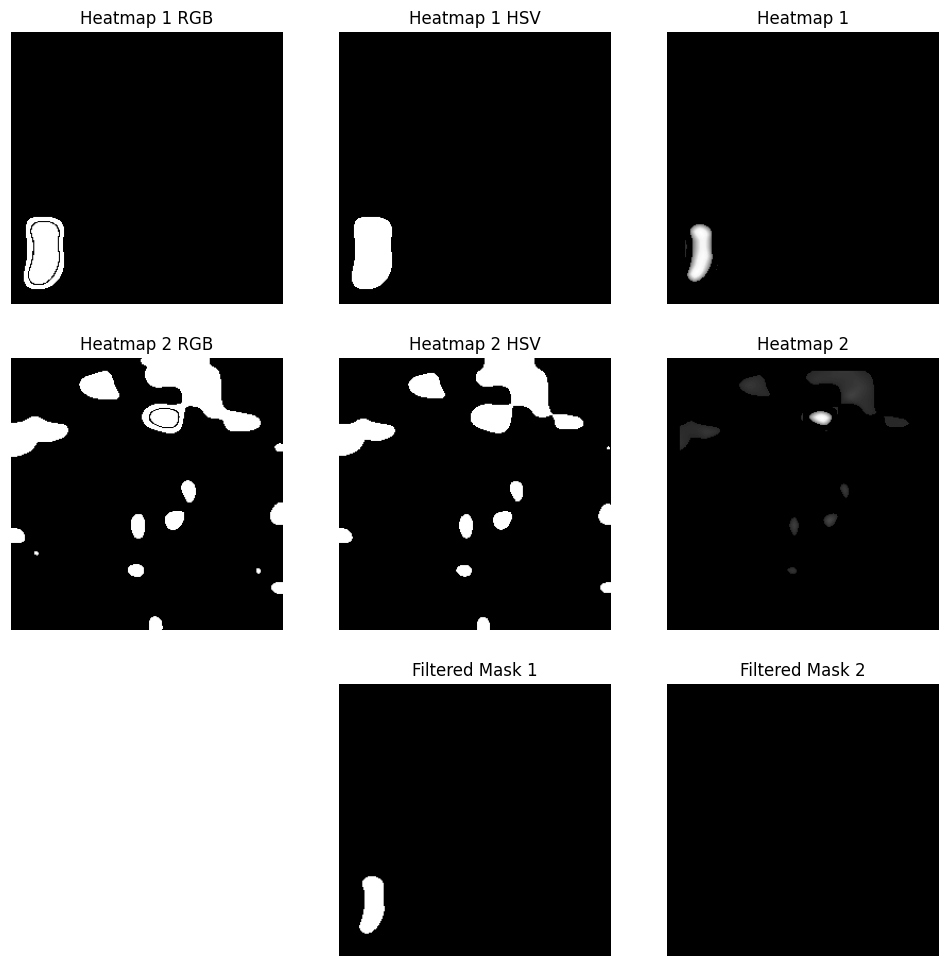

In [43]:
h1, h2 = threshold(heatmap1, heatmap2)

In [29]:
# por cada componente calcular la intensidad y si es mas grande que la mediana se queda, si no se va

# aplicar mascara en ambas imagenes
    # si en una imagen azul y la otra rojo -> no está
    # si en una imagen azul-verde y la otra azul-verde -> se ha movido / tapado


# aplicar segundo threshold más smooth en el caso que no detecte nada por ser muy restrictivo
# o empezar por uno mas ligth